In [1]:
import numpy as np
import gym
from gym import spaces, logger
from gym.utils import seeding
import copy
import matplotlib.pyplot as plt
%matplotlib inline

# VM Packing

This model is a multi-dimensional bin packing model that will provide a more challenging RL environment to learn with. The algo needs to minimize the number of VM's while managing both CPU and memory constraints across identical physical machines in a data center. The demand will be generated stochastically based on actual VM traces from Azure. There will be two versions, one with permanent packing and a second with temporary packing as VM's get removed some service.

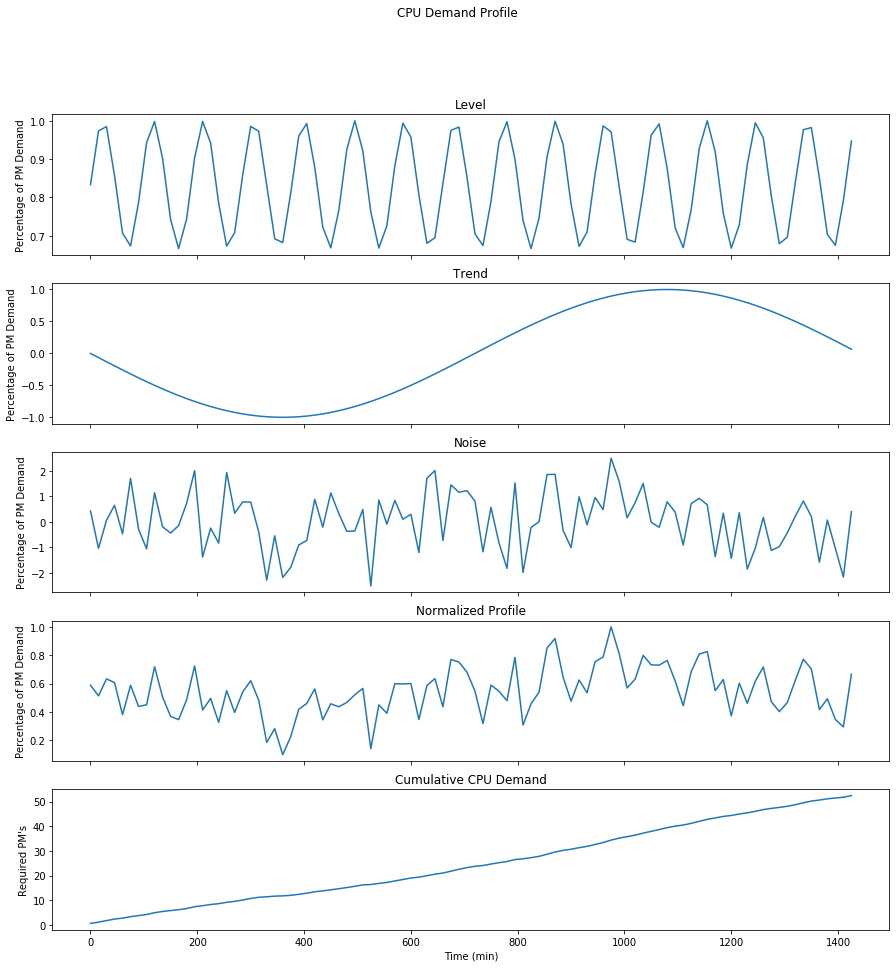

In [2]:
# Placeholder CPU demand model
t_int = 15
n_steps = int(1440 / t_int) # 1 day, 15 minute intervals
steps = np.arange(n_steps)
level = np.abs(np.sin(steps) + 5)
noise = np.random.normal(size=n_steps)
trend = np.sin(steps / n_steps * 2*np.pi + np.pi)
x = level + noise + trend
x /= x.max()

fig, ax = plt.subplots(5, 1, figsize=(15,15), sharex=True)

ax[0].plot(steps*t_int, level/np.max(level))
ax[0].set_title('Level')
ax[0].set_ylabel('Percentage of PM Demand')

ax[1].plot(steps*t_int, trend)
ax[1].set_title('Trend')
ax[1].set_ylabel('Percentage of PM Demand')

ax[2].plot(steps*t_int, noise)
ax[2].set_title('Noise')
ax[2].set_ylabel('Percentage of PM Demand')

ax[3].plot(steps*t_int, x)
ax[3].set_title('Normalized Profile')
ax[3].set_ylabel('Percentage of PM Demand')

ax[4].plot(steps*t_int, np.cumsum(x))
ax[4].set_title('Cumulative CPU Demand')
ax[4].set_xlabel('Time (min)')
ax[4].set_ylabel("Required PM's")

plt.suptitle('CPU Demand Profile')
plt.show()

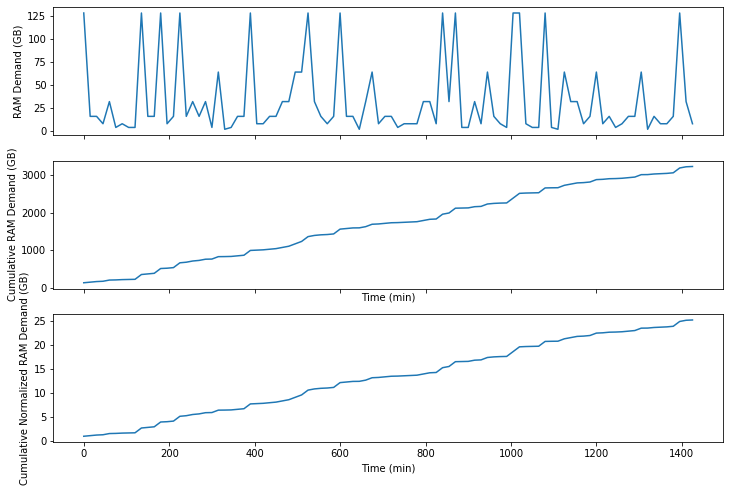

In [3]:
# Placeholder RAM demand model
t_int = 15
n_steps = int(1440 / t_int) # 1 day, 15 minute intervals
steps = np.arange(n_steps)

ram_levels = np.array([2, 4, 8, 16, 32, 64, 128])
# Assume levels are poisson distributed around 3 with each 
# value mapping to one of the levels
x = np.random.poisson(lam=3, size=n_steps)
ram_profile = [ram_levels[i] if i < len(ram_levels) else max(ram_levels) for i in x]

fig, ax = plt.subplots(3, 1, figsize=(12,8), sharex=True)

ax[0].plot(steps*t_int, ram_profile)
ax[0].set_ylabel('RAM Demand (GB)')

ax[1].plot(steps*t_int, np.cumsum(ram_profile))
ax[1].set_ylabel('Cumulative RAM Demand (GB)')
ax[1].set_xlabel('Time (min)')

ax[2].plot(steps*t_int, np.cumsum(ram_profile / max(ram_levels)))
ax[2].set_ylabel('Cumulative Normalized RAM Demand (GB)')
ax[2].set_xlabel('Time (min)')
plt.show()

In [170]:
# Placeholder demand generation function
def generate_demand():
    t_int = 15
    n_steps = int(1440 / t_int) # 1 day, 15 minute intervals
    steps = np.arange(n_steps)
    level = np.abs(np.sin(steps) + 5)
    noise = np.random.normal(size=n_steps)
    trend = np.sin(steps / n_steps * 2*np.pi + np.pi)
    cpu_demand = level + noise + trend
    cpu_demand /= cpu_demand.max()
    
    ram_levels = np.array([2, 4, 8, 16, 32, 64, 128])
    # Assume levels are poisson distributed around 3 with each 
    # value mapping to one of the levels
    ram_sample = np.random.poisson(lam=3, size=n_steps)
    ram_demand = np.array([ram_levels[i] 
        if i < len(ram_levels) else max(ram_levels) 
        for i in ram_sample]) / max(ram_levels)
    return np.vstack([cpu_demand, ram_demand]).T

In [248]:
# Build VM Packing MDP
class VMPackingEnv(gym.Env):
    
    def __init__(self):
        # Normalized Capacities
        self.cpu_capacity = 1
        self.ram_capacity = 1
        self.loads = np.array([1, 2]) # Indices for loads in state
        self.step_limit = 60 * 24 / 15
        self.n_pms = 100 # Number of physical machines to choose from
        
        self.observation_space = spaces.Box(
            low=np.zeros((self.n_pms, 3), dtype=np.float32),
            high=np.ones((self.n_pms, 3), dtype=np.float32),
            dtype=np.float32)
        self.action_space = spaces.Discrete(self.n_pms)
        
        self.state = self.reset()
        
    def step(self, action):
        done = False
        pm_state = self.state[0]
        if action < 0 or action >= self.n_pms:
            raise ValueError('Invalid Action')
        elif any(pm_state[action, 0] + self.demand[self.step_count] > 1):
            # Demand doesn't fit into PM
            reward = -100
            done = True
        else:
            if pm_state[action, 0] == 0:
                # Open PM if closed
                pm_state[action, 0] = 1
            pm_state[action, self.loads] += self.demand[self.step_count]
            reward = np.sum(pm_state[:, 0] * 
                (pm_state[:, 1] - 1 + pm_state[:, 2] - 1))
            
        if self.step_count >= self.step_limit:
            done = True
            reward = 0
        self.state = (pm_state, self.demand[self.step_count])
        self.step_count += 1
        return self.state, reward, done, {}
    
    def reset(self):
        self.step_count = 0
        self.demand = generate_demand()
        self.state = (np.zeros((self.n_pms, 3)), self.demand[0])
        return self.state

In [247]:
env = VMPackingEnv()
n_episodes = 100
ep_totals = []
step_totals = []
for ep in range(n_episodes):
    env.reset()
    done = False
    rewards = []
    while done == False:
        action = env.action_space.sample()
        s, r, done, _ = env.step(action)
        rewards.append(r)
    ep_totals.append(sum(rewards))
    step_totals.append(env.step_count)
    
np.mean(ep_totals)

-221.50946399388403

In [178]:
np.mean(step_totals)

13.55

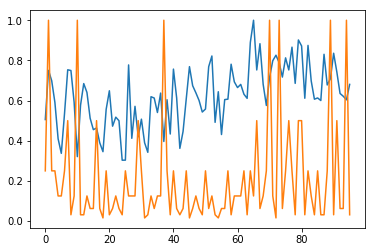

In [179]:
plt.plot(env.demand)

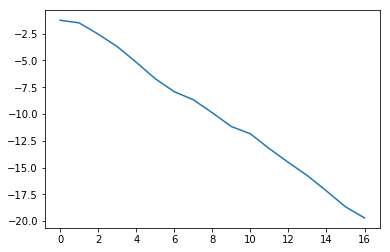

In [182]:
plt.plot(rewards[:-1])

# VM Packing with Finite Duration

In reality, VM's come online, then offline as time progresses. Here, we simulate an unknown and finite duration for VM's meaning that resources can be freed up as time progresses. 

To simulate this, we'll generate a dictionary for each process that determines when it comes off line.

In [207]:
demand = generate_demand()
def generate_durations(demand):
    return {i: np.random.randint(low=i+1, high=len(demand)+1)
        for i, j in enumerate(demand)}

In [251]:
class TempVMPackingEnv(VMPackingEnv):
    
    def __init__(self):
        super().__init__()       
        self.state = self.reset()
        
    def step(self, action):
        done = False
        pm_state = self.state[0]
        if action < 0 or action >= self.n_pms:
            raise ValueError('Invalid Action')
        elif any(pm_state[action, 0] + self.demand[self.step_count] > 1):
            # Demand doesn't fit into PM
            reward = -100
            done = True
        else:
            if pm_state[action, 0] == 0:
                # Open PM if closed
                pm_state[action, 0] = 1
            pm_state[action, self.loads] += self.demand[self.step_count]
            self.assignments[self.step_count] = action
        
        # Remove processes
        if self.step_count in self.durations.values():
            for process in self.durations.keys():
                # Remove process from PM
                if self.durations[process] == self.step_count:
                    pm = self.state[process]
                    pm_state[pm, self.loads] -= env.demand[process]
                    # Shut down PM's if state is 0
                    if pm_state[pm, self.loads].sum() == 0:
                        pm_state[pm, 0] = 0
            
        if self.step_count >= self.step_limit:
            done = True
            reward = 0
            
        if not done:
            reward = np.sum(pm_state[:, 0] * 
                (pm_state[:, 1] - 1 + pm_state[:, 2] - 1))
        
        self.state = (pm_state, self.demand[self.step_count])
        self.step_count += 1
        
        return self.state, reward, done, {}
        
    def reset(self):
        self.step_count = 0
        self.assignments = {}
        self.demand = generate_demand()
        self.durations = generate_durations(self.demand)
        self.state = (np.zeros((self.n_pms, 3)), self.demand[0])
        return self.state

In [292]:
env = TempVMPackingEnv()
done = False
rewards = []
states = []
while done == False:
    action = env.action_space.sample()
    s, r, done, _ = env.step(action)
    rewards.append(r)
    states.append((s[0].copy(), s[1].copy()))

In [293]:
for proc in range(env.step_count):
    val = env.durations[proc]
    if val < env.step_count:
        print(proc, env.durations[proc])

1 5


In [294]:
# Check to see the assignments worked properly
proc = 1
print("Process {} assigned to PM {} and removed at step {}.".format(
    proc, env.assignments[proc], env.durations[proc]))

Process 1 assigned to PM 38 and removed at step 5.


In [295]:
states[proc][1]

array([0.53545405, 1.        ])

In [296]:
states[proc-1][0][env.assignments[proc]]

array([0., 0., 0.])

In [297]:
states[proc][0][env.assignments[proc]]

array([1.        , 0.53545405, 1.        ])

In [303]:
states[env.durations[proc]][0][env.assignments[proc]]

array([0., 0., 0.])

In [308]:
np.vstack([s[0][env.assignments[proc]] for s in states])

array([[0.        , 0.        , 0.        ],
       [1.        , 0.53545405, 1.        ],
       [1.        , 0.53545405, 1.        ],
       [1.        , 0.53545405, 1.        ],
       [1.        , 0.53545405, 1.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ]])